In [1]:
from Functions import *


In [2]:
''' loop parameters '''
NN = 300
slope_slope_list = np.linspace(0, 1, NN) # slope of slope error of quadratic heat bump [urad/mm]

if_plot = 1
if_loop = 1			# to loop or not to loop


In [3]:
''' Beam parameters '''
N = 2048			# number of sampling points
E0 = 12665			# photon energy [eV]
tau = 100			# pulse duration [fs]
window = 10000		# total simulation time window [fs]

''' OE parameters '''
hkl = [4,4,0]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}


In [4]:
''' Define beamline '''
crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
							  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)
if alphaAsym <= 0:
	print('\n***\n***\n*** Bragg angle smaller than grazing angle')

f1 = 9.737399163879598
f2 = 10.

devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)

mirror_x = (devices[3].length/2) * np.linspace(-1,1,5000) * 1e3 # mirror axis 1D [mm]


b 1.00
b 1.00
b 9.52
crystal 2 incidence angle: 56.31 degrees
crystal 2 exit angle: 5.01 degrees
b 1.00
b 0.10


In [5]:
''' propagate '''
blockPrint()
mono_beamline = beamline.Beamline(devices[:9])

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus'])
tfin = time.time()

t_axis, t_pulse, t_pulse_fit = get_pulse(pulse, 'focus')
energy_axis, spectrum, spectrum_fit = get_spectrum(pulse,'focus',integrated=True)

C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
''' IO '''
path = '../{} eV/'.format(E0)
make_dir(path)

fig_path = path+'/heat_bump/'
make_dir(fig_path)

hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'heat_bump_{}_{}keV'.format(
	hkl_, round(beam_params['photonEnergy']/1000.,4))

blockPrint()


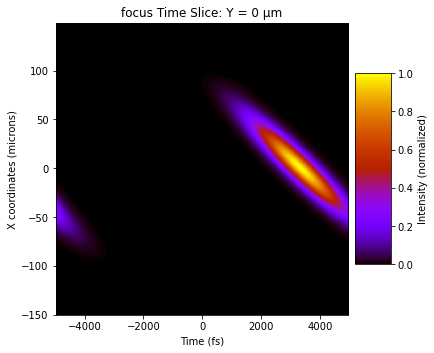

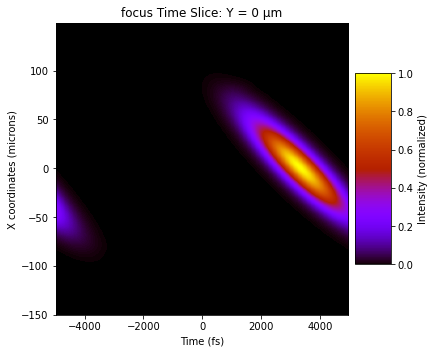

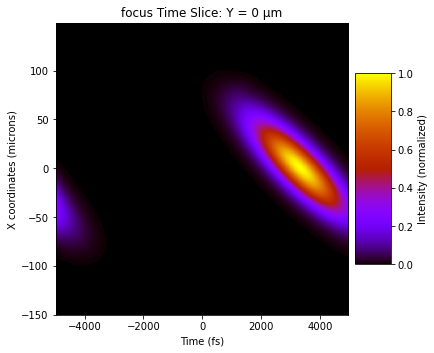

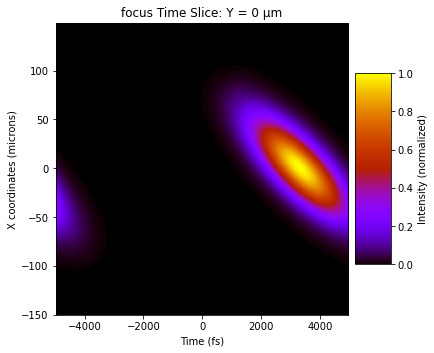

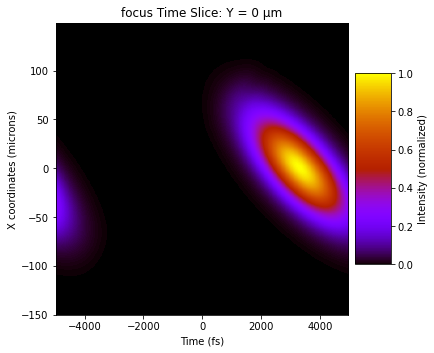

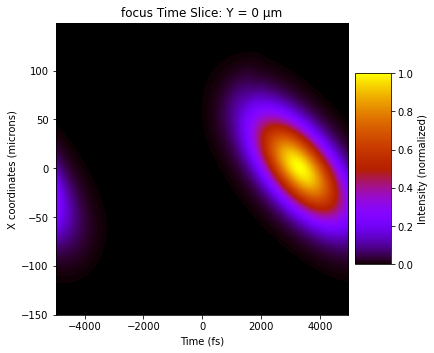

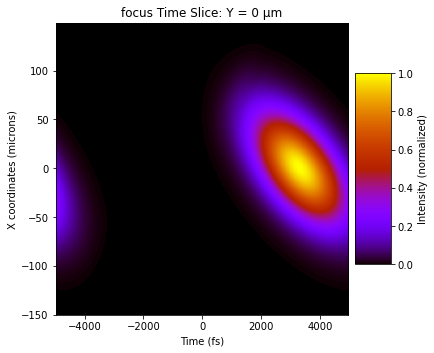

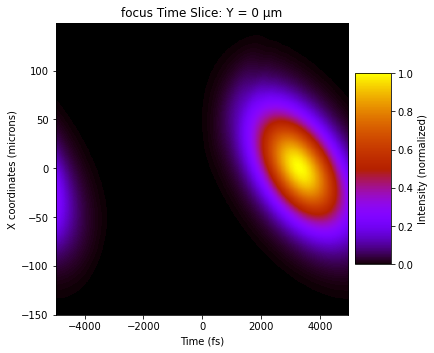

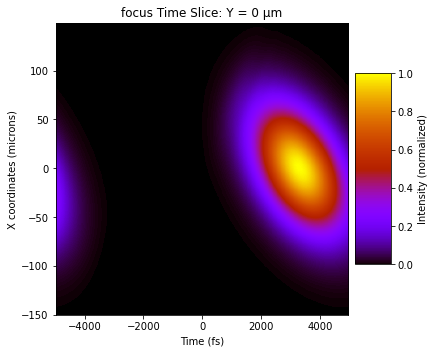

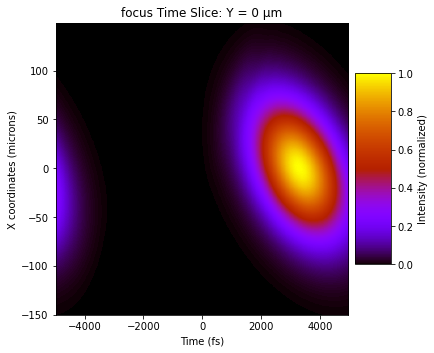

In [7]:
''' slope_error scan demo at focus '''
if if_plot == 1:
    for slope_slope in np.linspace(0,1,10):
        fig_name = 'heat_bump_slope_error_scan_{}_{}keV_{}urad_per_mm'.format(
            hkl_, round(beam_params['photonEnergy']/1000.,4), round(slope_slope,2))
        slope = mirror_x*slope_slope # slope error of quadratic heat bump [urad]
        shapeError = slope * mirror_x # quadratic heat bump [nm]

        devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                                 alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
        add_shapeError(devices, shapeError, crystal=2)
        mono_beamline = beamline.Beamline(devices[:9])    # initialize beamline
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
        pulse.propagate(beamline=mono_beamline, screen_names=['focus'])
        pulse.imshow_time_slice('focus')
        plt.savefig(fig_path+fig_name+'.png')


In [8]:
pulse.x['focus'].min()

-0.00015

In [9]:
%%capture capt
''' loop '''
if if_loop == 1:
    pulse_list = np.zeros((NN, t_axis.size))
    pulse_fit_list = np.zeros_like(pulse_list)
    spectrum_list = np.zeros((NN, energy_axis.size))
    spectrum_fit_list = np.zeros_like(spectrum_list)

    duration = np.zeros(NN)
    tilt = np.zeros_like(duration)
    bw = np.zeros_like(duration)
    throughput = np.zeros_like(duration)
    cent_E = np.zeros_like(duration)

    for i, slope_slope in enumerate(slope_slope_list):
        slope = mirror_x*slope_slope # slope error of quadratic heat bump [urad]
        shapeError = slope * mirror_x # quadratic heat bump [nm]
        
        # pulse duration and tilt
        devices = define_devices(f1,f2,slit_width = 100e-6, hkl = hkl,
                             alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
        add_shapeError(devices, shapeError, crystal=2)
        
        mono_beamline = beamline.Beamline(devices[:9])
        beam_params['photonEnergy'] = E0
        pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
        pulse.propagate(beamline=mono_beamline, screen_names=['focus'])
        centroid, duration[i] = pulse.pulse_duration('focus')
        tilt[i] = pulse.pulsefront_tilt('focus')
        _, pulse_list[i], pulse_fit_list[i] = get_pulse(pulse, 'focus')

        # else (closed slit)
        devices = define_devices(f1,f2,slit_width = 100e-6, hkl = hkl,
                             alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
        add_shapeError(devices, shapeError, crystal=2)
        
        mono_beamline = beamline.Beamline(devices[:9])
        beam_params['photonEnergy'] = E0
        pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
        pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus'])
        bw[i] = pulse.pulse_bandwidth('focus')
        throughput[i] = pulse.throughput('im0','focus')
        cent_E[i] = pulse.central_energy('focus')
        _, spectrum_list[i], spectrum_fit_list[i] = get_spectrum(pulse,'focus',integrated=True)

    with h5py.File(fig_path+fname+'.h5','w') as f:
        f.create_dataset('slope_error', data=slope_slope_list)
        f.create_dataset('duration', data=duration)
        f.create_dataset('pulse_list', data=pulse_list)
        f.create_dataset('pulse_fit_list', data=pulse_fit_list)
        f.create_dataset('tilt', data=tilt)
        f.create_dataset('bandwidth', data=bw)
        f.create_dataset('throughput', data=throughput)
        f.create_dataset('central_energy', data=cent_E)
        f.create_dataset('spectrum_list', data=spectrum_list)
        f.create_dataset('spectrum_fit_list', data=spectrum_fit_list)


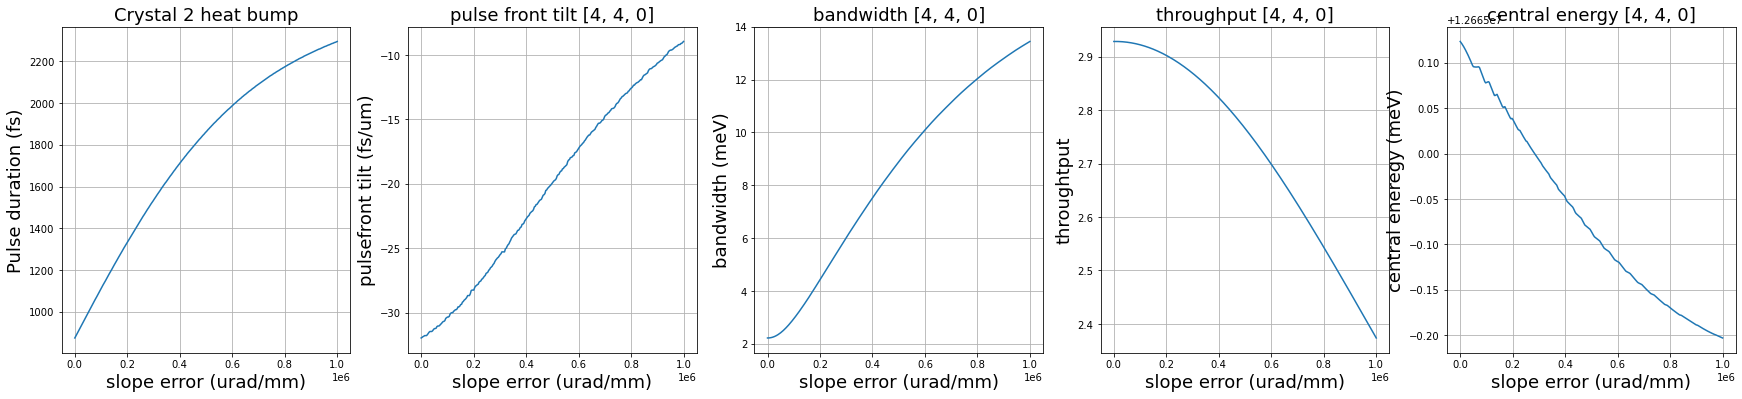

In [10]:
''' plot '''
with h5py.File(fig_path+fname+'.h5', 'r') as f:
    slope_slope_list = f['slope_error'][:]
    duration = f['duration'][:]
    pulse_list = f['pulse_list'][:]
    pulse_fit_list = f['pulse_fit_list'][:]
    tilt = f['tilt'][:]
    bw = f['bandwidth'][:]
    throughput = f['throughput'][:]
    cent_E = f['central_energy'][:]
    spectrum_list = f['spectrum_list'][:]
    spectrum_fit_list = f['spectrum_fit_list'][:]

# plots
xx = slope_slope_list * 1e6
xlabel = 'slope error (urad/mm)'

# pulse duration
plt.figure(figsize=(30,6))
plt.subplot(1,5,1)
plt.plot(xx, np.abs(duration))
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('Pulse duration (fs)',fontsize=(18))

plt.grid()
plt.title('Crystal 2 heat bump',fontsize=(18))

# pulsefront tilt
plt.subplot(1,5,2)
plt.plot(xx, tilt)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

plt.grid()
plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))
# bandwidth
plt.subplot(1,5,3)
plt.plot(xx, 1e3*bw)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('bandwidth (meV)',fontsize=(18))

plt.grid()
plt.title('bandwidth {}'.format(hkl),fontsize=(18))

# throughput
plt.subplot(1,5,4)
plt.plot(xx, throughput)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('throughtput',fontsize=(18))

plt.grid()
plt.title('throughput {}'.format(hkl),fontsize=(18))

# central energy
plt.subplot(1,5,5)
plt.plot(xx, 1e3*cent_E)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('central eneregy (meV)',fontsize=(18))

plt.grid()
plt.title('central energy {}'.format(hkl),fontsize=(18))

plt.savefig(fig_path+fname+'.png')


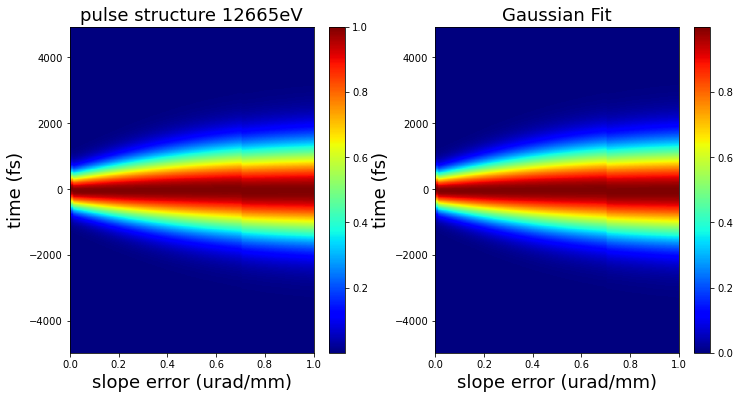

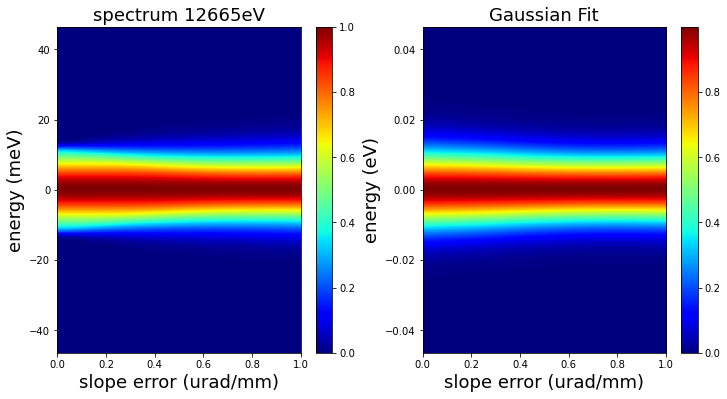

In [11]:
# pulse structure scan
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(pulse_list.T, cmap='jet',
          extent = [slope_slope_list.min(), slope_slope_list.max(), t_axis.min(), t_axis.max()])
plt.colorbar()
plt.xlabel(xlabel,fontsize=18)
plt.ylabel('time (fs)',fontsize=18)
plt.axis('tight')
plt.title('pulse structure {}eV'.format(E0),fontsize=18)

plt.subplot(1,2,2)
plt.imshow(pulse_fit_list.T, cmap='jet',
          extent = [slope_slope_list.min(), slope_slope_list.max(), t_axis.min(), t_axis.max()])
plt.colorbar()
plt.xlabel(xlabel,fontsize=18)
plt.ylabel('time (fs)',fontsize=18)
plt.axis('tight')
plt.title('Gaussian Fit',fontsize=18)
plt.savefig(fig_path+'pulse_structure_scan_{}_{}keV.png'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4)))

# spectrum scan
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(spectrum_list.T, cmap='jet',
          extent = [slope_slope_list.min(), slope_slope_list.max(), 1e3*energy_axis.min(), 1e3*energy_axis.max()])
plt.colorbar()
plt.xlabel(xlabel,fontsize=18)
plt.ylabel('energy (meV)',fontsize=18)
plt.axis('tight')
plt.title('spectrum {}eV'.format(E0),fontsize=18)

plt.subplot(1,2,2)
plt.imshow(spectrum_fit_list.T, cmap='jet',
          extent = [slope_slope_list.min(), slope_slope_list.max(), energy_axis.min(), energy_axis.max()])
plt.colorbar()
plt.xlabel(xlabel,fontsize=18)
plt.ylabel('energy (eV)',fontsize=18)
plt.axis('tight')
plt.title('Gaussian Fit',fontsize=18)
plt.savefig(fig_path+'spectrum_scan_{}_{}keV.png'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4)))